### the randomized experiment (RCT/ AB test)

reminder:

correlation (more generally, *association*) is not causation

...unless...maybe.. it is.

we have a treatment/intervention $ X \in \{0,1\}$

and we have an outcome variable $ Y $

`avg(Y | X = 1) - avg(Y | X = 0) = avg treatment effect (on the treated) + bias`

for now, let's give hand-wavy definitions:

treatment effect = "avg difference in $Y$ when the treatment is given vs when it is not given"

bias = "avg difference in $Y$ if noone got the treatment"

the nice thing about AB tests, is that they are designed to eliminate bias

how?

bias can be eliminated through random assignment of $X$.


**data source**:

[cookie cats](https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing)

In [90]:
import pandas as pd
#cats = pd.read_csv('../cookie_cats.csv')
cats = pd.read_csv('/Users/alenadocherty/Downloads/Projects/Cookie_cats/cookie_cats.csv')

# mobile gaming dataset
# quite large: tens of thousands of observations

# we have to make up a story about the experimental set up:

# we have a mobile game (a game you play on your cell phone)
# intervention/experimental condition/X - "the thing that's different between the two groups"
# group A sees the gate at level 30
# group B sees the gate at level 40
# we measure 3 outcomes as a function of the intervention:
# total number of games played from the moment the experiment was launched to 14 days after.
# and retention .. after 1 day and after 7 days.

# let's assume prior to the experiment ALL players saw the gate at level 30
# that would mean the experimental condition is "player sees the gate at level 40"

cats.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


<Axes: title={'center': 'percentage of players who return after 7 days'}, xlabel='version', ylabel='%'>

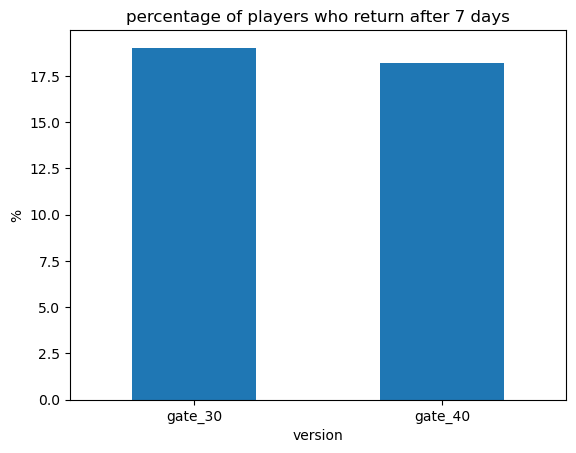

In [2]:
import matplotlib.pyplot as plt

retention_7_barplot_data = cats.groupby('version')['retention_7'].mean()*100

retention_7_barplot_data.plot.bar(title = "percentage of players who return after 7 days",rot = 0,ylabel = "%")

quick review

pvalue what does it mean?

probability of type 1 error, i.e. false positive rate, i.e. probability of rejecting the null hypothesis when you should NOT have

pvalue = "in a world where there's no difference between group A and B, we should expect to see data that looks like this pvalue percentage of the time"

if you do 1,000,000 hypothesis tests and get 1,000,000 pvalues of .0499999 (which leads you to reject the null every time) you will have 50,000 false positives. 

In [3]:
# randomization - we have to take it for granted here.
# what data would we need to do the random assignment ourselves
# we want to make sure that "on average" the players in group A and B 
# had the same level of engagement before the experiment

# what hypothesis test should we use
# t-test, specifically two-sample unpaired independent t-test

# null hypothesis: mean(sum of game rounds for group A) - mean(sum of game rounds for group B) = 0
# alternative hypothesis: ~null hypothesis 
# mean(sum of game rounds for group A) - mean(sum of game rounds for group B) != 0

# significance threshold
# most people arbitrarily use .05
# if p(false positive) < .05 we will decide to kind of believe the result

gate_30 = cats.loc[cats['version'] == "gate_30","sum_gamerounds"] # group A
gate_40 = cats.loc[cats['version'] == "gate_40","sum_gamerounds"] # group B

from scipy.stats import ttest_ind
ttest_ind(gate_30,gate_40)

Ttest_indResult(statistic=0.8910426211362967, pvalue=0.37290868247405207)

interpretation:

we fail to reject the null hypothesis

let's check our intuition about hypothesis testing

we've done this experiment...and now we want to explain where the variability in the data comes from, and there's really only three options:

**option 1**: all the variability is due to the systematic effect of the treatment

`gate_30_gr = (120, 120, 120, 120, ....)`

`gate_40_gr = (119, 119, 119, 119, ....)`

as you can see, this is highly unlikely to be the case.

**option 2**: all the variability is due to randomness (noise) 

**^^^ when we do a hypothesis test, we're testing this ^^^**

**option 3:** the variability is some combination of systematic effect and noise

**^^^ when we reject the null, we are choosing to believe this ^^^**


In [4]:
# next
# 7 day retention (rate, category) ~ version (categorical (gate_30,40))
# proportions z test
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
# prep the data
retention_gate_30 = cats.loc[cats['version'] == "gate_30","retention_7"] # group A
retention_gate_40 = cats.loc[cats['version'] == "gate_40","retention_7"] # group B
count = np.array([retention_gate_30.sum(),retention_gate_40.sum()])
nobs = np.array([retention_gate_30.shape[0],retention_gate_40.shape[0]])
# run the test
# wait a sec
# what are the null/alt hypotheses
# null: retention rate gate_30 = retention_rate gate_40
# alt:  retention rate gate_30 != retention_rate gate_40 (or just: ~null)

_, pval = proportions_ztest(count, nobs)
# print the result
print(f'{round(pval,3)}')


0.002


In [29]:
# the test only hints at the strength and direction of the effect
# we need to take a closer look
cats.groupby('version')['retention_7'].agg(['sum','mean'])

,sum,mean
version,,
gate_30,8502,0.190201
gate_40,8279,0.182000


there's usually more than one way to answer the same question

statistical methods are like little robots - some are designed for a single purpose and others have more flexible capabilities

for example, we used a t-test to evaluate sum_gamerounds (numeric) ~ version (categorical)

are there other tools that we could apply. what about a regression?

`avg(sum_gamerounds | version) = beta0 + beta_version*version{1,0}`

## ISSUE #6 . Calculate statistical power for t-test using Cohen's d


### Non-modularised code - commented out

In [111]:
'''
import statsmodels.stats.power as smp
import numpy as np

nobs = np.array([retention_gate_30.shape[0],retention_gate_40.shape[0]])

# Means of the group A and group B
mean = np.array([retention_gate_30.mean(), retention_gate_40.mean()])

# Standard deviation of each group
std = np.array([retention_gate_30.std(), retention_gate_40.std()])

# Pooled standard deviation from pooled standard variance pooled_var
pooled_var = ((nobs[0] - 1) * std[0]**2 + (nobs[1] - 1) * std[1]**2) / (nobs[0] + nobs[1] - 2)
pooled_std = np.sqrt(pooled_var)

# Cohen's d
d = (mean[0]-mean[1])/pooled_std

# Power calculation for t-test
effect_size = d
alpha = 0.05

# nobs = nobs[0] used as being the smallest of two nobs[0] and nobs[1]
power_ttest = smp.ttest_power(effect_size = d, nobs = nobs[0], alpha = alpha,  alternative='two-sided')

print('Number of observations:', nobs)
print('Mean:', mean)
print('Standard deviation:', std)
print('Pooled standard deviation:', round(pooled_std, 3))
print("Cohen's d:",  round(d, 3))
print('Power for t-test:', round(power_ttest, 3))

'''

Number of observations: [44700 45489]
Mean: [0.19020134 0.18200004]
Standard deviation: [0.39246431 0.38584881]
Pooled standard deviation: 0.389
Cohen's d: 0.021
Power for t-test: 0.994


## Modularised code

In [132]:
import pandas as pd
import numpy as np
import statsmodels.stats.power as smp

# calculating pooled standard deviation
def calculate_pooled_std(nobs, std):   
    pooled_var = ((nobs[0] - 1)*std[0]**2 + (nobs[1]-1)*std[1]**2)/(nobs[0] + nobs[1] -2)
    pooled_std = np.sqrt(pooled_var)
    return pooled_std

# calculating Cohen's d to quantify the difference between means of two groups
def calculate_cohen_d(mean, pooled_std):
    d = (mean[0] - mean[1])/pooled_std
    return d
    
# calculating the power of t-test 
def calculate_power_ttest(mean, std, nobs):
    # Defaults
    alpha = 0.05
    alternative = 'two-sided'
   
    pooled_std = calculate_pooled_std(nobs, std)
    d = calculate_cohen_d(mean, pooled_std)
    power_ttest = smp.ttest_power(effect_size=d, nobs=nobs[0], alpha=alpha, alternative=alternative)
    return power_ttest

#power_ttest = calculate_power_ttest(mean, std, nobs)


def main():
    cats = pd.read_csv('../cookie_cats.csv')
    #cats = pd.read_csv('/Users/alenadocherty/Downloads/Projects/Cookie_cats/cookie_cats.csv')

    # preparing the data
    retention_gate_30 = cats.loc[cats['version'] == 'gate_30', 'retention_7']
    retention_gate_40 = cats.loc[cats['version'] == 'gate_40', 'retention_7']
    nobs = np.array([retention_gate_30.shape[0],retention_gate_40.shape[0]])
    mean = np.array([retention_gate_30.mean(), retention_gate_40.mean()])
    std = np.array([retention_gate_30.std(), retention_gate_40.std()])

    # calculating power for t-test
    power_ttest = calculate_power_ttest(mean, std, nobs)
    
    
    print('Number of observations:', nobs)
    print('Mean:', mean)
    print('Standard deviation:', std)
    print('Pooled standard deviation:', round(pooled_std, 3))
    print("Cohen's d:", round(d, 3))
    print('Power for t_test:', round(power_ttest, 3)) 
      
# main entry point: calls main function  dirctly
if __name__ == '__main__':
    main()

Number of observations: [44700 45489]
Mean: [0.19020134 0.18200004]
Standard deviation: [0.39246431 0.38584881]
Pooled standard deviation: 0.389
Cohen's d: 0.021
Power for t_test: 0.994
